In [1]:
from torchvision.models import resnet50
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import pandas as pd
from PIL import Image, ImageOps
from numbers import Number
import pytorch_lightning as pl
import torch.nn.functional as F
from typing import Optional
from pytorch_lightning.callbacks import ModelCheckpoint, GPUStatsMonitor, EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import AUROC, Precision, Recall
from sklearn.model_selection import train_test_split
import os.path
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

In [10]:
# 12/12 some stuff for paper
split = pd.read_csv('/scratch/arz8448/capstone/data/mimic-cxr-jpg/mimic-cxr-2.0.0-split.csv')
test = split[split.split=='test']

In [15]:
len(set(list(test.subject_id)) & set(list(pd.read_csv('/scratch/arz8448/capstone/data/mimic-iv/core/patients.csv').subject_id)))

293

In [8]:
pd.read_csv('/scratch/arz8448/capstone/data/mimic-iv/core/patients.csv').subject_id

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN
3,10004222,M,0,2161,2014 - 2016,NaN
4,10005325,F,0,2154,2011 - 2013,NaN
...,...,...,...,...,...,...
382273,19998203,M,29,2132,2011 - 2013,NaN
382274,19998350,M,52,2127,2011 - 2013,NaN
382275,19999068,M,63,2161,2011 - 2013,NaN
382276,19999270,M,33,2184,2014 - 2016,NaN


In [6]:
# 12/7 Way to get test metrics
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
# Equivalent to Dataset.py
class CheXpertDataset(Dataset):
    '''
    Trimmed Dataset for diagnosis classification task
    '''    
    def __init__(self, split, sample=1.0, rgb=False, image_size=(224,224), data_dir=chexpert_path_yl): #sample is not used right now        
        super().__init__()       
        self.data_dir = data_dir
        assert split in ('train','val','validation','validate','test')
        self.split = split if split not in ['validation','val','validate'] else 'valid'
        # Use augmented images for the training split
        if self.split == 'train':
            #self.data_dir = '/scratch/yl7971/capstone/CheXpert-Aug/'
            self.data_dir = '/scratch/yl7971/capstone/CheXpert-v1.0/'
        self.data_csv = pd.read_csv(chexpert_path_yl + 'seth_'+ self.split + '.csv',
                                        index_col = ['Path'])

        self.image_size = image_size
        self.rgb = rgb # True = model input images need to be RGB; False = Grayscale
        
        if self.split in ['train', 'all']:
            # Transforms used are based on SimCLR:
            # https://github.com/sthalles/SimCLR/tree/
            ks = int(0.1*self.image_size[0])
            ks = ks - ((ks+1)%2)
            
            self.transforms = transforms.Compose([
                transforms.RandomResizedCrop(size=self.image_size, scale=(0.6, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomAffine((-20, 20),
                                        translate=(0.1, 0.1),
                                        scale=(0.95, 1.05)),
                transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6,1.4)),
                transforms.GaussianBlur(kernel_size=ks, sigma=(0.1,3.0))
            ])
                
        else:
            self.transforms = nn.Identity()
        
    def __len__(self):
        return self.data_csv.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        subset = self.data_csv.iloc[idx]
        path = self.data_csv.index[idx].split('/',1)[1] #Path to image
        image = Image.open(self.data_dir+path)     
        if not self.rgb: #The pre-processed images are already RGB, just grayscale them for our modified resnet
            image = image.convert('L')
        # Image handling
        image = self.transforms(image)
        image = transforms.ToTensor()(image)    
        # Diagnosis labels
        label = torch.tensor(subset.astype(float)) #e.g. [1.0, 0.0, 0.0, 0.0, 1.0]

        return {'image': image, 'label': label}
    
def collate_cheXpert(batch):
    image = torch.stack([item['image'] for item in batch])
    label = torch.stack([item['label'] for item in batch])

    return image, label
    
    
class CheXpertDataModule(pl.LightningDataModule):

    def __init__(self,batch_size=64,num_workers=8,train_frac=1.0,rgb=False):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_frac = train_frac #gets passed to 'sample' in dataset
        self.rgb = rgb
    def setup(self, stage:Optional[str]=None) -> None:

        self.train_data = CheXpertDataset(sample=self.train_frac, rgb=self.rgb, split='train')
        self.val_data = CheXpertDataset(rgb=self.rgb, split='validate')
        self.test_data = CheXpertDataset(rgb=self.rgb, split='test')
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, persistent_workers=True,
                          collate_fn=collate_cheXpert, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, persistent_workers=True,
                          collate_fn=collate_cheXpert, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, persistent_workers=True,
                          collate_fn=collate_cheXpert, pin_memory=True)
    
    
batch_size = 64
num_workers = 8 #match CPU count and increase RAM if increase
num_classes=5

### GET POS_WEIGHTS ### --- For weighted loss function
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1].split('.')[0]] = torch.Tensor(pos_weight) # these will be very similar across our 3 balanced splits
    
'''
RN50 = nn.Sequential(
    resnet50(),
    nn.Linear(1000, 512),
    nn.Linear(512, num_classes)
)'''
RN50 = nn.Sequential(
        m.model.image1,
        m.model.image_project,
        nn.Linear(512, num_classes)
    )
class DiagnosisModule_2(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.image_model = model[0]
        self.image_project = model[1]
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = model[2]
        
        
        #self.criterion_train_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weights['train'])
        self.criterion_train_weighted = nn.BCEWithLogitsLoss()
        self.criterion_val = nn.BCEWithLogitsLoss()
        self.criterion_test = nn.BCEWithLogitsLoss()
        self.auroc_train = AUROC(num_classes=num_classes, compute_on_step=False) #Computes every epoch
        self.auroc_val = AUROC(num_classes=num_classes, compute_on_step=False)
        self.auroc_test = AUROC(num_classes=num_classes, average=None, compute_on_step=False)
        self.sm = nn.Sigmoid()
        self.precision_metric = Precision(num_classes, average='macro',compute_on_step=False)
        self.recall_metric = Recall(num_classes, average='macro',compute_on_step=False)
    def training_step(self, batch, batch_idx):

        x, y = batch
        x = self.image_project(self.image_model(x))
        x = self.dropout(x)
        y_hat = self.classifier(x)
        loss = self.criterion_train_weighted(y_hat, y)
        with torch.no_grad():
            self.auroc_train(self.sm(y_hat),y.long())
        self.log('train_loss', loss)
        self.log('train_auc', self.auroc_train, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        #Runs with no grad
        x, y = batch
        x = self.image_project(self.image_model(x))
        x = self.dropout(x)
        y_hat = self.classifier(x)
        loss = self.criterion_val(y_hat, y)
        probas = self.sm(y_hat)            
        self.auroc_val(probas, y.long())
        self.log('val_loss', loss)
        self.log('val_auc', self.auroc_val, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        #Runs with no grad
        x, y = batch
        x = self.image_project(self.image_model(x))
        x = self.dropout(x)
        y_hat = self.classifier(x)
        loss = self.criterion_test(y_hat, y)
        probas = self.sm(y_hat) 
        #print(torch.round(probas))
        self.auroc_test(probas, y.long())
        self.precision_metric(probas, y.long())
        self.recall_metric(probas, y.long())
        
        self.log('test_loss', loss)
        self.log('test_auc1', self.auroc_test[0], on_step=False, on_epoch=True, metric_attribute='auroc_test')
        self.log('test_auc2', self.auroc_test[1], on_step=False, on_epoch=True, metric_attribute='auroc_test')
        self.log('test_auc3', self.auroc_test[2], on_step=False, on_epoch=True, metric_attribute='auroc_test')
        self.log('test_auc4', self.auroc_test[3], on_step=False, on_epoch=True, metric_attribute='auroc_test')
        self.log('test_auc5', self.auroc_test[4], on_step=False, on_epoch=True, metric_attribute='auroc_test')
        self.log('test_recall', self.recall_metric, on_step=False, on_epoch=True)
        self.log('test_precision', self.precision_metric, on_step=False, on_epoch=True)

        return #{'test_loss': loss, 'test_auc': self.auroc_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-6) # Per Manning
        scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3) # Per Manning
        lr_scheduler_config = {
            'scheduler': scheduler,
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val_loss',
            'strict': True
        }
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}
acc = None if torch.cuda.device_count() < 2 else 'ddp'
drd = '/scratch/yl7971/capstone/DT/outputs/'

trainer = pl.Trainer(default_root_dir=drd,
                     #gpus=torch.cuda.device_count(),
                     accelerator='cpu', #precision=16,
                     check_val_every_n_epoch=1, max_epochs=100)
data = CheXpertDataModule(batch_size,num_workers,1.0,True)
#print('SETUP DATA')
#ckpt = '/scratch/yl7971/capstone/DT/outputs/12847450.ckpt'
ckpt = '/scratch/yl7971/capstone/DT/outputs/lightning_logs/version_12956417/checkpoints/epoch=2-step=10238.ckpt'
model = DiagnosisModule_2.load_from_checkpoint(ckpt,model=RN50)
trainer.test(model,data,ckpt)

NameError: name 'm' is not defined

In [7]:
np.mean([0.8253011703491211,
0.8984127044677734,
0.9164782762527466,
0.8172889947891235,
0.9083027839660645])

0.8731567859649658

In [57]:
# 12/6 Let's redo the data splits
from skmultilearn.model_selection import IterativeStratification

#1. Normal splits

chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
usecols=['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']

df = pd.read_csv(chexpert_path_em + 'valid.csv', index_col = ['Path'],
                 usecols = usecols)
df = df.fillna(0)
df.iloc[:,[0,1,3,4]] = df.iloc[:,[0,1,3,4]] != 0.0
df.iloc[:,2] = df.iloc[:,2] == 1.0
df.to_csv(chexpert_path_yl + 'seth_test.csv') # Original Valid is Test
df = pd.read_csv(chexpert_path_em + 'train.csv', index_col = ['Path'], usecols = usecols)
df = df.fillna(0)
df.iloc[:,[0,1,3,4]] = df.iloc[:,[0,1,3,4]] != 0.0
df.iloc[:,2] = df.iloc[:,2] == 1.0
valid = df.sample(5000)
train = df.drop(valid.index)
train.to_csv(chexpert_path_yl + 'seth_train.csv')
valid.to_csv(chexpert_path_yl + 'seth_valid.csv')

In [63]:
### GET POS_WEIGHTS ###
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1].split('.')[0]] = torch.Tensor(pos_weight) # these will be very similar for balanced splits
pos_weights

{'train': tensor([ 5.3718,  2.4228, 14.0964,  2.3284,  1.2840]),
 'valid': tensor([ 5.1805,  2.5236, 14.8730,  2.3490,  1.2862]),
 'test': tensor([2.4412, 4.2000, 6.0909, 1.9250, 2.4925])}

In [66]:
#2. Bal5 splits

train = pd.read_csv(chexpert_path_em + 'train.csv',usecols = usecols)
train = train.fillna(0)
train.iloc[:,[1,2,4,5]] = train.iloc[:,[1,2,4,5]] != 0.0
train.iloc[:,3] = train.iloc[:,3] == 1.0
valid = pd.read_csv(chexpert_path_em + 'valid.csv',usecols = usecols)
valid = valid.fillna(0)
valid.iloc[:,[1,2,4,5]] = valid.iloc[:,[1,2,4,5]] != 0.0
valid.iloc[:,3] = valid.iloc[:,3] == 1.0
all_df = pd.concat([train,valid],ignore_index=True)

val_test_size = (5000+len(valid))/len(all_df)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[val_test_size, 1.0-val_test_size])
X = all_df.iloc[:,0]
y = all_df.iloc[:,1:]
train_indexes, val_and_test_indexes = next(stratifier.split(X, y))
X_train = X.iloc[train_indexes]
y_train = y.iloc[train_indexes, :]
X_val_test = X.iloc[val_and_test_indexes]
y_val_test = y.iloc[val_and_test_indexes, :]
train = pd.concat([X_train, y_train], axis=1)
val_test = pd.concat([X_val_test, y_val_test], axis=1)
train.to_csv(chexpert_path_yl + 'seth_train_bal5.csv', index=False)

test_size = len(valid)/len(val_test)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[test_size, 1.0-test_size])
val_indexes, test_indexes = next(stratifier.split(X_val_test, y_val_test))
X_val = X_val_test.iloc[val_indexes]
y_val = y_val_test.iloc[val_indexes, :]
X_test = X_val_test.iloc[test_indexes]
y_test = y_val_test.iloc[test_indexes, :]
valid = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)
valid.to_csv(chexpert_path_yl + 'seth_valid_bal5.csv', index=False)
test.to_csv(chexpert_path_yl + 'seth_test_bal5.csv', index=False)

In [67]:
### GET POS_WEIGHTS ###
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '_bal5.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1].split('.')[0]] = torch.Tensor(pos_weight) # these will be very similar for balanced splits
pos_weights

{'train': tensor([ 5.3618,  2.4263, 14.0953,  2.3284,  1.2849]),
 'valid': tensor([ 5.3613,  2.4247, 14.1057,  2.3267,  1.2841]),
 'test': tensor([ 5.3243,  2.4412, 13.6250,  2.3429,  1.2941])}

In [75]:
#3. Downsampling
x = 10
threshold = 8.0
df = all_df.set_index('Path')
while True:
    pos_weight = (df.count() - df.sum()) / df.sum()
    if max(pos_weight) < threshold:
        break
    minority_label = max(range(len(pos_weight)), key=pos_weight.__getitem__)
    removable_is = [i for i, x in enumerate(df.iloc[:,minority_label]) if not x]
    if min(pos_weight) < 1.0: # If majority label has too many positive examples:
        majority_label = min(range(len(pos_weight)), key=pos_weight.__getitem__)
        majority_pos_i = [i for i, x in enumerate(df.iloc[:,majority_label]) if x]
        removable_is = list(set(removable_is) & set(majority_pos_i))
    xx = min(x,len(removable_is))
    df = df.drop(df.index[(random.sample(removable_is,xx))])
    
df = df.reset_index()

val_test_size = 5234/len(df)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[val_test_size, 1.0-val_test_size])
X = df.iloc[:,0]
y = df.iloc[:,1:]
train_indexes, val_and_test_indexes = next(stratifier.split(X, y))
X_train = X.iloc[train_indexes]
y_train = y.iloc[train_indexes, :]
X_val_test = X.iloc[val_and_test_indexes]
y_val_test = y.iloc[val_and_test_indexes, :]
train = pd.concat([X_train, y_train], axis=1)
val_test = pd.concat([X_val_test, y_val_test], axis=1)
train.to_csv(chexpert_path_yl + 'seth_train_bal5_ds2.csv', index=False)

test_size = len(valid)/len(val_test)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[test_size, 1.0-test_size])
val_indexes, test_indexes = next(stratifier.split(X_val_test, y_val_test))
X_val = X_val_test.iloc[val_indexes]
y_val = y_val_test.iloc[val_indexes, :]
X_test = X_val_test.iloc[test_indexes]
y_test = y_val_test.iloc[test_indexes, :]
valid = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)
valid.to_csv(chexpert_path_yl + 'seth_valid_bal5_ds2.csv', index=False)
test.to_csv(chexpert_path_yl + 'seth_test_bal5_ds2.csv', index=False)

In [14]:
# 12/5 Exploring down-sampling
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'

### GET POS_WEIGHTS ###
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '_bal5.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1]] = torch.Tensor(pos_weight) # these will be very similar for balanced splits
pos_weights

{'train': tensor([ 7.2623,  3.2770, 14.0953,  5.6848,  1.5929]),
 'valid': tensor([ 7.2645,  3.2772, 14.1057,  5.6845,  1.5920]),
 'test': tensor([ 7.3571,  3.2545, 13.6250,  5.6857,  1.6000])}

In [25]:
# 12/5 Exploring down-sampling
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'

### GET POS_WEIGHTS AFTER REMOVING ALL FALSE ROWS ###
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '_bal5.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    csv = csv[-(~csv).all(axis=1)] # Discard all False rows
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1]] = torch.Tensor(pos_weight) # these will be very similar for balanced splits
pos_weights

{'train': tensor([4.1312, 1.6562, 8.3747, 3.1515, 0.6103]),
 'valid': tensor([4.1339, 1.6570, 8.3837, 3.1524, 0.6102]),
 'test': tensor([4.2143, 1.6545, 8.1250, 3.1714, 0.6222])}

In [2]:
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
usecols=['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']

train = pd.read_csv(chexpert_path_em + 'train.csv',usecols = usecols)
train.iloc[:,1:] = train.iloc[:,1:] == 1.0
valid = pd.read_csv(chexpert_path_em + 'valid.csv',usecols = usecols)
valid.iloc[:,1:] = valid.iloc[:,1:] == 1.0
all_df = pd.concat([train,valid],ignore_index=True)
all_df.index = all_df.Path
all_df = all_df.iloc[:,1:]
all_df

,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
Path,,,,,
CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00002/study2/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00002/study1/view2_lateral.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00003/study1/view1_frontal.jpg,False,True,False,False,False
...,...,...,...,...,...
CheXpert-v1.0/valid/patient64736/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/valid/patient64737/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/valid/patient64738/study1/view1_frontal.jpg,True,True,False,False,False


In [11]:
# Dumb way to downsample:
# At each step, remove x rows at random that doesn't have the most minority label
#      -And has the most majority label if it falls below 1.0
# Recompute pos_weights
# If any weight fell below some threshold, stop. (?)
# If the most minority falls below some threshold, stop. (?)
x = 10
threshold = 8.0
df = all_df
while True:
    pos_weight = (df.count() - df.sum()) / df.sum()
    if max(pos_weight) < threshold:
        break
    minority_label = max(range(len(pos_weight)), key=pos_weight.__getitem__)
    removable_is = [i for i, x in enumerate(df.iloc[:,minority_label]) if not x]
    if min(pos_weight) < 1.0: # If majority label has too many positive examples:
        majority_label = min(range(len(pos_weight)), key=pos_weight.__getitem__)
        majority_pos_i = [i for i, x in enumerate(df.iloc[:,majority_label]) if x]
        removable_is = list(set(removable_is) & set(majority_pos_i))
    xx = min(x,len(removable_is))
    df = df.drop(df.index[(random.sample(removable_is,xx))])
df

,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
Path,,,,,
CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00002/study1/view2_lateral.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00004/study1/view2_lateral.jpg,False,False,False,False,False
CheXpert-v1.0/train/patient00005/study1/view1_frontal.jpg,False,False,False,False,False
...,...,...,...,...,...
CheXpert-v1.0/valid/patient64735/study1/view1_frontal.jpg,False,False,False,True,False
CheXpert-v1.0/valid/patient64737/study1/view1_frontal.jpg,False,False,False,False,False
CheXpert-v1.0/valid/patient64738/study1/view1_frontal.jpg,True,True,False,False,False


In [19]:
# 3.0 = 15478 LOL; 5.0 = 54668; 7.0 = 113678; 8.0 = 133338
# Let's start by removing all False rows and doing the bal5 splits again
# If doesn't work, I can downsample using above, maybe use a higher threshold or limit by absolute data size
from skmultilearn.model_selection import IterativeStratification

chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'

df = df.reset_index()

val_test_size = 5234/len(df)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[val_test_size, 1.0-val_test_size])
X = df.iloc[:,0]
y = df.iloc[:,1:]
train_indexes, val_and_test_indexes = next(stratifier.split(X, y))
X_train = X.iloc[train_indexes]
y_train = y.iloc[train_indexes, :]
X_val_test = X.iloc[val_and_test_indexes]
y_val_test = y.iloc[val_and_test_indexes, :]
train = pd.concat([X_train, y_train], axis=1)
val_test = pd.concat([X_val_test, y_val_test], axis=1)
train.to_csv(chexpert_path_yl + 'seth_train_bal5_ds2.csv', index=False)

test_size = len(valid)/len(val_test)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[test_size, 1.0-test_size])
val_indexes, test_indexes = next(stratifier.split(X_val_test, y_val_test))
X_val = X_val_test.iloc[val_indexes]
y_val = y_val_test.iloc[val_indexes, :]
X_test = X_val_test.iloc[test_indexes]
y_test = y_val_test.iloc[test_indexes, :]
valid = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)
valid.to_csv(chexpert_path_yl + 'seth_valid_bal5_ds2.csv', index=False)
test.to_csv(chexpert_path_yl + 'seth_test_bal5_ds2.csv', index=False)

In [32]:
torch.tensor(pd.read_csv(chexpert_path_yl + 'seth_valid_bal5_ds2.csv', index_col = ['Path']).iloc[2].astype(float))

tensor([0., 1., 0., 0., 1.], dtype=torch.float64)

In [27]:
### GET POS_WEIGHTS ###
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '_bal5_ds2.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1]] = torch.Tensor(pos_weight) # these will be very similar for balanced splits
pos_weights

{'train': tensor([7.2829, 3.2854, 7.9999, 5.6558, 1.5530]),
 'valid': tensor([7.2781, 3.2882, 7.9928, 5.6578, 1.5536]),
 'test': tensor([7.3571, 3.2545, 8.0000, 5.6857, 1.5435])}

In [22]:
# 12/1 testing loading from pretrained checkpoint
sd = {}
for k,v in torch.load('best_pretrained_weights.ckpt',map_location=torch.device('cpu'))['state_dict'].items():
    if 'image1' in k:
        sd[k[13:]] = v
RN50 = resnet50()    
RN50.conv1 = nn.Conv2d(1,64,kernel_size=7, stride=2, padding=3, bias=False)
RN50.load_state_dict(sd)

<All keys matched successfully>

In [8]:
%ls ../CheXpert-v1.0/

seth_test.csv        seth_train_0.1.csv   seth_valid.csv       train.csv*
seth_test_bal.csv    seth_train_1.0.csv   seth_valid_bal.csv   valid/
seth_test_bal5.csv   seth_train_bal.csv   seth_valid_bal5.csv  valid.csv*
seth_train_0.01.csv  seth_train_bal5.csv  train/


In [2]:
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
pos_weights = {}
for file in [chexpert_path_yl + 'seth_' + split + '_bal5.csv' for split in ['train','valid','test']]:
    csv = pd.read_csv(file, index_col=['Path'])
    pos_weight = (csv.count() - csv.sum()) / csv.sum() # neg count / pos count
    pos_weights[file.split('_')[1]] = torch.Tensor(pos_weight)

In [3]:
pos_weights

{'train': tensor([ 7.2623,  3.2770, 14.0953,  5.6848,  1.5929]),
 'valid': tensor([ 7.2645,  3.2772, 14.1057,  5.6845,  1.5920]),
 'test': tensor([ 7.3571,  3.2545, 13.6250,  5.6857,  1.6000])}

In [3]:
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
usecols=['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']

train = pd.read_csv(chexpert_path_em + 'train.csv',usecols = usecols)
train.iloc[:,1:] = train.iloc[:,1:] == 1.0
valid = pd.read_csv(chexpert_path_em + 'valid.csv',usecols = usecols)
valid.iloc[:,1:] = valid.iloc[:,1:] == 1.0
all_df = pd.concat([train,valid],ignore_index=True)

In [5]:
all_df.groupby(usecols[1:]).size().reset_index().rename(columns={0:'count'})

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion,count
0,False,False,False,False,False,84754
1,False,False,False,False,True,39420
2,False,False,False,True,False,16156
3,False,False,False,True,True,15104
4,False,False,True,False,False,5178
5,False,False,True,False,True,4138
6,False,False,True,True,False,792
7,False,False,True,True,True,1445
8,False,True,False,False,False,8017
9,False,True,False,False,True,4512


In [8]:
pd.read_csv(chexpert_path_yl + 'seth_valid_bal5.csv').groupby(usecols[1:]).size().reset_index().rename(columns={0:'count'})

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion,count
0,False,False,False,False,False,1894
1,False,False,False,False,True,883
2,False,False,False,True,False,361
3,False,False,False,True,True,337
4,False,False,True,False,False,115
5,False,False,True,False,True,92
6,False,False,True,True,False,19
7,False,False,True,True,True,32
8,False,True,False,False,False,178
9,False,True,False,False,True,102


In [6]:
# Make a balanced train/val/test split for multilabel classification
# Order = up to which order of combination of labels are we balanacing
# 1 = we just match each label's distribution (in our case, 5 distributions) in each split
# bal.csv = order of 2
# bal5.csv = order of 5
from skmultilearn.model_selection import IterativeStratification
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
usecols=['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']

train = pd.read_csv(chexpert_path_em + 'train.csv',usecols = usecols)
train.iloc[:,1:] = train.iloc[:,1:] == 1.0
valid = pd.read_csv(chexpert_path_em + 'valid.csv',usecols = usecols)
valid.iloc[:,1:] = valid.iloc[:,1:] == 1.0
all_df = pd.concat([train,valid],ignore_index=True)

val_test_size = (5000+len(valid))/len(all_df)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[val_test_size, 1.0-val_test_size])
X = all_df.iloc[:,0]
y = all_df.iloc[:,1:] == 1.0
train_indexes, val_and_test_indexes = next(stratifier.split(X, y))
X_train = X.iloc[train_indexes]
y_train = y.iloc[train_indexes, :]
X_val_test = X.iloc[val_and_test_indexes]
y_val_test = y.iloc[val_and_test_indexes, :]
train = pd.concat([X_train, y_train], axis=1)
val_test = pd.concat([X_val_test, y_val_test], axis=1)
train.to_csv(chexpert_path_yl + 'seth_train_bal5.csv', index=False)

test_size = len(valid)/len(val_test)
stratifier = IterativeStratification(n_splits=2, order=5, sample_distribution_per_fold=[test_size, 1.0-test_size])
val_indexes, test_indexes = next(stratifier.split(X_val_test, y_val_test))
X_val = X_val_test.iloc[val_indexes]
y_val = y_val_test.iloc[val_indexes, :]
X_test = X_val_test.iloc[test_indexes]
y_test = y_val_test.iloc[test_indexes, :]
valid = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)
valid.to_csv(chexpert_path_yl + 'seth_valid_bal5.csv', index=False)
test.to_csv(chexpert_path_yl + 'seth_test_bal5.csv', index=False)

In [ ]:
# Make a balanced 0.1 and 0.5 train data
# done below

In [2]:
#no need to run this
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'

In [45]:
# no need to run this
train_paths = pd.read_csv(chexpert_path_em + 'train.csv', usecols = ['Path']).Path
val_paths = pd.read_csv(chexpert_path_em + 'valid.csv', usecols = ['Path']).Path

pre_process = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Normalize(mean=0.4860, std=0.2874),
            transforms.Pad([0,0,max(0,max(img.size)-img.size[0]),max(0,max(img.size)-img.size[1])]),
            transforms.Resize(224,InterpolationMode.NEAREST),
            transforms.ToPILImage()
        ])

for p in train_paths:
    path = p.split('/',1)[1]
    img = Image.open(chexpert_path_em + path)
    pre_process(img).convert('RGB').save(chexpert_path_yl + path)
    
print ('Done with train images')

for p in val_paths:
    path = p.split('/',1)[1]
    img = Image.open(chexpert_path_em + path)
    pre_process(img).convert('RGB').save(chexpert_path_yl + path)
    
print ('Done with val images')

KeyboardInterrupt: 

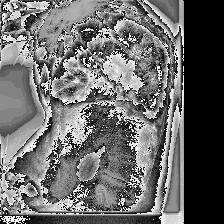

In [7]:
Image.open(chexpert_path_yl + 'train/patient00002/study1/view2_lateral.jpg')

In [144]:
%rm /scratch/yl7971/capstone/CheXpert-v1.0/seth_train_0.01.csv

In [146]:
from skmultilearn.model_selection import IterativeStratification
chexpert_path_em = '/scratch/em4449/stanford_data/CheXpert-v1.0/'
chexpert_path_yl = '/scratch/yl7971/capstone/CheXpert-v1.0/'
usecols=['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']
# Create valid of 5000, test is original valid.
# I should make valid split just sample from random, since the test split isn't balanced to match train anyways.
# Splitting val to match test would be cheating.
if not os.path.isfile(chexpert_path_yl + 'seth_train_0.01.csv'):
    df = pd.read_csv(chexpert_path_em + 'valid.csv', index_col = ['Path'],
                     usecols = usecols)
    df = df == 1.0
    df.to_csv(chexpert_path_yl + 'seth_test.csv')
    df = pd.read_csv(chexpert_path_em + 'train.csv',usecols = usecols)
    #test_size = 5000/len(df)
    #stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    #X = df.iloc[:,0]
    #y = df.iloc[:,1:] == 1.0
    #train_indexes, val_indexes = next(stratifier.split(X, y))
    #X_train = X.iloc[train_indexes]
    #y_train = y.iloc[train_indexes, :]
    #X_val = X.iloc[val_indexes]
    #y_val = y.iloc[val_indexes, :]
    #train = pd.concat([X_train, y_train], axis=1)
    #valid = pd.concat([X_val, y_val], axis=1)
    df.iloc[:,1:] = df.iloc[:,1:] == 1.0
    valid = df.sample(5000)
    train = df.drop(valid.index)
    X_train = train.iloc[:,0]
    y_train = train.iloc[:,1:]
    train.to_csv(chexpert_path_yl + 'seth_train_1.0.csv', index=False)
    valid.to_csv(chexpert_path_yl + 'seth_valid.csv', index=False)
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.1, 1.0-0.1])
    _, small_indexes = next(stratifier.split(X_train, y_train))
    X_train_small = X.iloc[small_indexes]
    y_train_small = y.iloc[small_indexes]
    train_small = pd.concat([X_train_small, y_train_small], axis=1)
    train_small.to_csv(chexpert_path_yl + 'seth_train_0.1.csv', index=False)
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.01, 1.0-0.01])
    _, smaller_indexes = next(stratifier.split(X_train, y_train))
    X_train_smaller = X.iloc[smaller_indexes]
    y_train_smaller = y.iloc[smaller_indexes]
    train_smaller = pd.concat([X_train_smaller, y_train_smaller], axis=1)
    train_smaller.to_csv(chexpert_path_yl + 'seth_train_0.01.csv', index=False)

In [4]:
# Equivalent to Dataset.py
class CheXpertDataset(Dataset):
    '''
    Trimmed Dataset for diagnosis classification task
    '''    
    def __init__(self, split, sample=1.0, rgb=False, image_size=(224,224), data_dir=chexpert_path_yl):        
        super().__init__()       
        self.data_dir = data_dir
        assert split in ('train','val','validation','validate','test')
        self.split = split if split not in ['validation','val','validate'] else 'valid'
        if split == 'train':
            self.data_csv = pd.read_csv(chexpert_path_yl + 'seth_train_' + str(sample) + '.csv',
                                        index_col = ['Path'])
        else:
            self.data_csv = pd.read_csv(chexpert_path_yl + 'seth_' + self.split + '.csv',
                                        index_col = ['Path'])
        self.image_size = image_size
        self.rgb = rgb
        
    def __len__(self):
        return self.data_csv.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        subset = self.data_csv.iloc[idx]
        path = self.data_csv.index[idx].split('/',1)[1]
        image = Image.open(self.data_dir+path)     
        #if self.rgb: #The pre-processed images are already RGB, just grayscale them for modified resnet
            #image = image.convert('RGB')
        # Image handling
        image = transforms.ToTensor()(image)    
        # Diagnosis labels
        label = torch.tensor(subset.astype(float))

        return {'image': image, 'label': label}
    
def collate_cheXpert(batch):
    image = torch.stack([item['image'] for item in batch])
    label = torch.stack([item['label'] for item in batch])

    return image, label
    
    
class CheXpertDataModule(pl.LightningDataModule):
    '''
    Parameters:
        split: bool or iterable. If True, creates train/test/val dataloaders;
            If False, creates a single dataloader for entire dataset;
            If iterable, creates only the dataloaders specified
        batch_size: Batch size
        num_workers: Number of workers
        tokenizer: The tokenizer to use for BERT
    '''
    def __init__(self,batch_size,num_workers,train_frac=1.0,rgb=False):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_frac = train_frac
        self.rgb = rgb
    def setup(self, stage:Optional[str]=None) -> None:

        self.train_data = CheXpertDataset(sample=self.train_frac, rgb=self.rgb, split='train')
        self.val_data = CheXpertDataset(rgb=self.rgb, split='validate')
        self.test_data = CheXpertDataset(rgb=self.rgb, split='test')
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, persistent_workers=True,
                          collate_fn=collate_cheXpert, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, persistent_workers=True,
                          collate_fn=collate_cheXpert, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, persistent_workers=True,
                          collate_fn=collate_cheXpert, pin_memory=True)

In [ ]:
### THIS PART ONWARDS IS FOR USING PRE-TRAINED WEIGHTS ###
# Todo: 1) Something to freeze for 200 runs and unfreeze
# https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2
# Maybe eaiser to just code it as 2 separate trainings with max_steps and load final state?
# 2) Freeze all except classification head
# Maybe just passing the right params to Adam will suffice

In [5]:

tune_all = True
image_net = True

acc = None
batch_size = 64
num_workers = 4
num_classes=5
train_frac=0.01
if tune_all:
    # Freeze ResNet and tune classification head only for 200 steps
    if image_net:
        RN50 = resnet50(pretrained=True)
    else:
        RN50 = resnet50()    
        RN50.conv1 = nn.Conv2d(1,64,kernel_size=7, stride=2, padding=3, bias=False)
        ### INSERT CODE TO LOAD PRETRAINING WEIGHTS HERE ###
        #RN50.load_state_dict(torch.load(WEIGHT_PATH))
    RN50.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(2048, num_classes)
    )    
    for name, param in RN50.named_parameters():
        if not 'fc' in name:
            param.requires_grad = False

    class DiagnosisModule_1(pl.LightningModule):
    
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.criterion = nn.BCEWithLogitsLoss()
            self.criterion_train_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weights['train'])
            self.criterion_val_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weights['valid'])
            self.criterion_test_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weights['test'])
        def training_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion_train_weighted(y_hat, y)
            with torch.no_grad():
                loss2 = self.criterion(y_hat,y)
            self.log('train_loss', loss)
            self.log('train_loss_unweighted',loss2)
            return loss

        def validation_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion_val_weighted(y_hat, y)
            loss2 = self.criterion(y_hat, y)
            self.log('val_loss', loss)
            self.log('val_loss_unweighted',loss2)
            return loss


        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
            return optimizer
    mc = ModelCheckpoint() # only saves last state
    max_steps= 200
    trainer = pl.Trainer(default_root_dir='/scratch/yl7971/capstone/DT/outputs/', gpus=[0],
                         accelerator=acc, callbacks=[mc], max_steps=max_steps,
                         max_epochs=2, check_val_every_n_epoch=1)
    data = CheXpertDataModule(batch_size,num_workers,train_frac,image_net)
    model = DiagnosisModule_1(RN50)
    trainer.fit(model, datamodule=data)
    print('Finished warming up classification head.')
    # Load last state, unfreeze, and train all
    '''
    This explicitly loads the last state, but not needed since RN50 is alreday in that state
    sd = {}
    for k,v in torch.load(mc.best_model_path)['state_dict'].items():
        sd[k[6:]] = v
    RN50.load_state_dict(sd)
    '''
    for p in RN50.parameters():
        p.requires_grad = True
    class DiagnosisModule_2(pl.LightningModule):

        def __init__(self, model):
            super().__init__()
            self.model = model
            self.criterion = nn.BCEWithLogitsLoss()
            self.auroc = AUROC(num_classes=num_classes, compute_on_step=False)
        def training_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)

            self.log('train_loss', loss)
            return loss

        def validation_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)

            self.log('val_loss', loss)
            return loss

        def test_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)
            sm = nn.Softmax(1)
            probas = sm(y_hat)            
            self.auroc.update(probas, y.long())
            self.log('test_loss', loss)
            self.log('test_auc', self.auroc, on_step=False, on_epoch=True, prog_bar=True)
            
            return {'test_loss': loss, 'test_auc': self.auroc}
        
        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-6)
            scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
            lr_scheduler_config = {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
                'monitor': 'val_loss',
                'strict': True
            }
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}
    mc_all = ModelCheckpoint(monitor='val_loss', every_n_epochs=1, save_last=True)
    callbacks = [
        mc_all,
        EarlyStopping(monitor='val_loss', patience=30)]

    trainer = pl.Trainer(default_root_dir='/scratch/yl7971/capstone/DT/outputs/', gpus=[0],
                         accelerator=acc, callbacks=callbacks,
                         check_val_every_n_epoch=1)
    data = CheXpertDataModule(batch_size,num_workers,train_frac,image_net)
    model = DiagnosisModule_2(RN50)
    trainer.fit(model, datamodule=data)
    print('Finished tuning all hparams.')
    test_res = trainer.test(ckpt_path="best")
    #test_res = trainer.test(model)
else: 
    # Freeze all except fc and train
    if image_net:
        RN50 = resnet50(pretrained=True)
    else:
        RN50 = resnet50()    
        RN50.conv1 = nn.Conv2d(1,64,kernel_size=7, stride=2, padding=3, bias=False)
        ### INSERT CODE TO LOAD PRETRAINING WEIGHTS HERE ###
        #RN50.load_state_dict(torch.load(WEIGHT_PATH))
    RN50.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(2048, num_classes)
    )     
    for name, param in RN50.named_parameters():
        if not 'fc' in name:
            param.requires_grad = False
    class DiagnosisModule_3(pl.LightningModule):
    
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.criterion = nn.BCEWithLogitsLoss()
            self.auroc = AUROC(num_classes=num_classes, compute_on_step=False)
        def training_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)

            self.log('train_loss', loss)
            return loss

        def validation_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)

            self.log('val_loss', loss)
            return loss
        
        def test_step(self, batch, batch_idx):

            x, y = batch
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)
            sm = nn.Softmax(1)
            probas = sm(y_hat)            
            self.auroc.update(probas, y.long())
            self.log('test_loss', loss)
            self.log('test_auc', self.auroc, on_step=False, on_epoch=True, prog_bar=True)
            
            return {'test_loss': loss, 'test_auc': self.auroc}

        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-6)
            scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
            lr_scheduler_config = {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
                'monitor': 'val_loss',
                'strict': True
            }
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}
    mc_fc_only = ModelCheckpoint(monitor='val_loss', every_n_epochs=1, save_last=True)
    callbacks = [
        mc_fc_only,
        EarlyStopping(monitor='val_loss', patience=30)
    ]
    trainer = pl.Trainer(default_root_dir='/scratch/yl7971/capstone/DT/outputs/', gpus=[0],
                         accelerator=acc, precision=16, callbacks=callbacks,
                         check_val_every_n_epoch=1)
    data = CheXpertDataModule(batch_size,num_workers,train_frac,image_net)
    model = DiagnosisModule_3(RN50)
    trainer.fit(model, datamodule=data)
    test_res = trainer.test(ckpt_path="best")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name                     | Type              | Params
---------------------------------------------------------------
0 | model                    | ResNet            | 23.5 M
1 | criterion                | BCEWithLogitsLoss | 0     
2 | criterion_train_weighted | BCEWithLogitsLoss | 0     
3 | criterion_val_weighted   | BCEWithLogitsLoss | 0     
4 | criterion_test_weighted  | BCEWithLogitsLoss | 0     
---------------------------------------------------------------
10.2 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.073    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ext3/miniconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 23.5 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | auroc     | AUROC             | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.073    Total estimated model params size (MB)


Finished warming up classification head.


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Finished tuning all hparams.


MisconfigurationException: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [50]:
if image_net:
    txt_file = 'Diag_CheXpert_imagenet_' + str(train_frac) + '.txt'
else:
    txt_file = 'Diag_CheXpert_ourweights_' + str(train_frac) + '.txt'
with open(txt_file, 'w') as file:
     file.write(json.dumps(test_res[0])) # use `json.loads` to do the reverse

In [ ]:
'''
54168089
To-Do
1) For measuring data efficiency, sample 1%/10%/all of training -- in dataset
2) Figure out testing with pytorch lightning -- measure AUC ----- DONE
'''